## Importing the necessary libraries

In [45]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.regularizers import L1

## Importing the NAB Dataset

In [128]:
df = pd.read_csv('./NAB/data/artificialNoAnomaly/art_daily_no_noise.csv')
df_test = pd.read_csv('./NAB/data/artificialWithAnomaly/art_daily_nojump.csv')

In [129]:
df.head()

,timestamp,value
0,2014-04-01 00:00:00,20.0
1,2014-04-01 00:05:00,20.0
2,2014-04-01 00:10:00,20.0
3,2014-04-01 00:15:00,20.0
4,2014-04-01 00:20:00,20.0


In [130]:
df_test.head()

,timestamp,value
0,2014-04-01 00:00:00,21.598011
1,2014-04-01 00:05:00,19.321392
2,2014-04-01 00:10:00,21.399938
3,2014-04-01 00:15:00,18.373916
4,2014-04-01 00:20:00,18.167499


In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4032 entries, 0 to 4031
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  4032 non-null   object 
 1   value      4032 non-null   float64
dtypes: float64(1), object(1)
memory usage: 63.1+ KB


In [132]:
df['timestamp'].min(), df['timestamp'].max()

('2014-04-01 00:00:00', '2014-04-14 23:55:00')

## Visualizing the Data

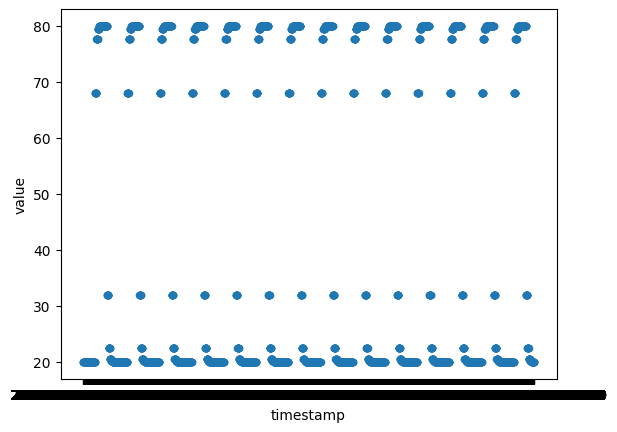

In [133]:
df.plot.scatter(x='timestamp', y='value')
plt.show()

In [134]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['timestamp'], y=df['value']))
fig.show()

## Data Preprocessing

In [167]:
# Train and Test Split
train = df.loc[df['timestamp'] < '2014-04-09']
test = df.loc[df['timestamp'] >= '2014-04-09']

anomaly_train = df_test.loc[df['timestamp'] < '2014-04-09']
anomaly_test = df_test.loc[df['timestamp'] >= '2014-04-09']

train.shape, test.shape

((2304, 2), (1728, 2))

In [168]:
# Scaling
scaler = StandardScaler()
scaler = scaler.fit(np.array(train['value']).reshape(-1,1))

train['value'] = scaler.transform(np.array(train['value']).reshape(-1,1))
test['value'] = scaler.transform(np.array(test['value']).reshape(-1,1))

C:\Users\nawaf\AppData\Local\Temp\ipykernel_13444\3561072758.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nawaf\AppData\Local\Temp\ipykernel_13444\3561072758.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



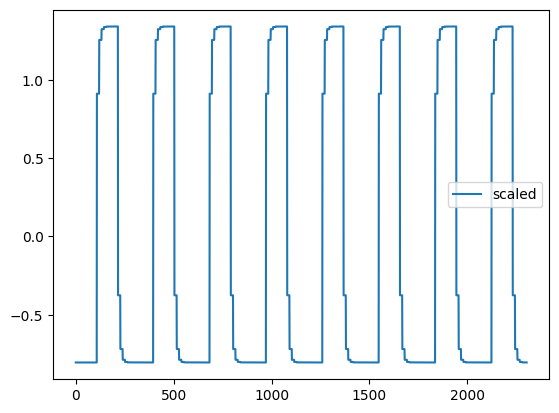

In [169]:
# Visualize scaled data
plt.plot(train['value'], label = 'scaled')
plt.legend()
plt.show()

In [180]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    X_out, y_out = [], []
    for i in range(len(X)-time_steps):
        X_out.append(X.iloc[i:(i+time_steps)].values)
        y_out.append(y.iloc[i+time_steps])
    
    return np.array(X_out), np.array(y_out)

X_train, y_train = create_sequences(train[['value']], train['value'])
X_test, y_test = create_sequences(test[['value']], test['value'])
print("Training input shape: ", X_train.shape)
print("Testing input shape: ", X_test.shape)

Training input shape:  (2274, 30, 1)
Testing input shape:  (1698, 30, 1)


## Building the Model

In [181]:
model = Sequential()
model.add(LSTM(128, activation = 'tanh', input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=L1(0.001)))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, activation = 'tanh', return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss="mse")
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 128)               66560     
                                                                 
 dropout_23 (Dropout)        (None, 128)               0         
                                                                 
 repeat_vector_12 (RepeatVec  (None, 30, 128)          0         
 tor)                                                            
                                                                 
 lstm_25 (LSTM)              (None, 30, 128)           131584    
                                                                 
 dropout_24 (Dropout)        (None, 30, 128)           0         
                                                                 
 time_distributed_11 (TimeDi  (None, 30, 1)            129       
 stributed)                                          

In [182]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')],
                    shuffle=False)

Epoch 1/20
64/64 [==============================] - 5s 38ms/step - loss: 0.5317 - val_loss: 0.3215
Epoch 2/20
64/64 [==============================] - 2s 27ms/step - loss: 0.2819 - val_loss: 0.2706
Epoch 3/20
64/64 [==============================] - 2s 31ms/step - loss: 0.2523 - val_loss: 0.2554
Epoch 4/20
64/64 [==============================] - 2s 26ms/step - loss: 0.2463 - val_loss: 0.2796
Epoch 5/20
64/64 [==============================] - 2s 27ms/step - loss: 0.2483 - val_loss: 0.2557
Epoch 6/20
64/64 [==============================] - 2s 25ms/step - loss: 0.2300 - val_loss: 0.2493
Epoch 7/20
64/64 [==============================] - 2s 33ms/step - loss: 0.2812 - val_loss: 0.2752
Epoch 8/20
64/64 [==============================] - 2s 31ms/step - loss: 0.2362 - val_loss: 0.2663
Epoch 9/20
64/64 [==============================] - 2s 39ms/step - loss: 0.2264 - val_loss: 0.2441
Epoch 10/20
64/64 [==============================] - 2s 38ms/step - loss: 0.2222 - val_loss: 0.2513
Epoch 11/

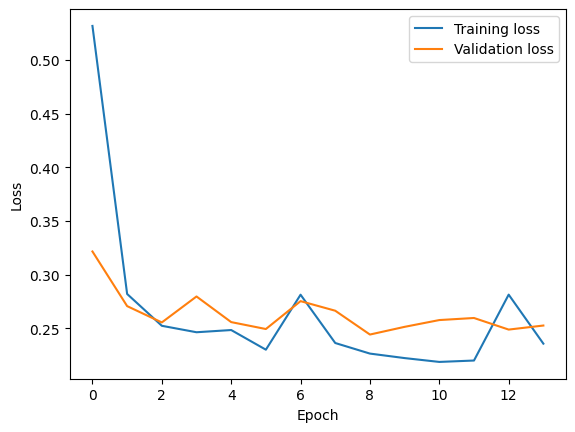

In [183]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

72/72 [==============================] - 1s 10ms/step
Reconstruction error threshold: 1.6418199366756838


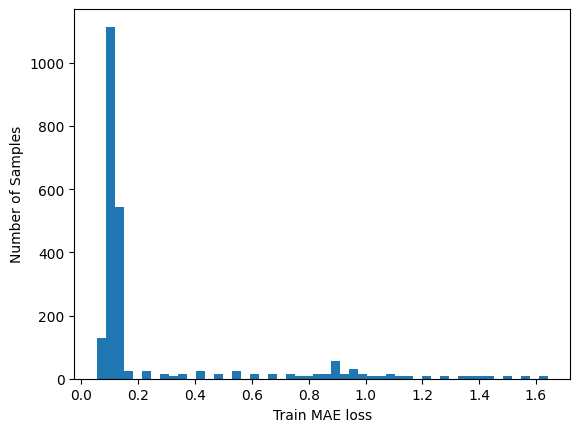

In [184]:
# Mean Absolute Error loss
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

# Set reconstruction error threshold
threshold = np.max(train_mae_loss)

print('Reconstruction error threshold:',threshold)

## Detecting Anomalies

54/54 [==============================] - 1s 12ms/step


Text(0, 0.5, 'Number of samples')

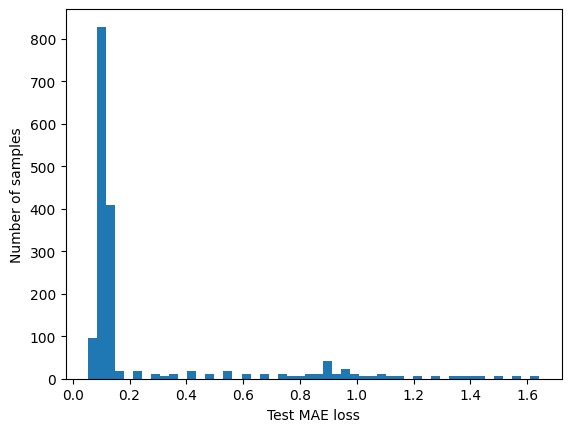

In [185]:
X_test_pred = model.predict(X_test, verbose=1)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [186]:
anomaly_df = pd.DataFrame(test[TIME_STEPS:])
anomaly_df['loss'] = test_mae_loss
anomaly_df['threshold'] = threshold
anomaly_df['anomaly'] = anomaly_df['loss'] > anomaly_df['threshold']

In [187]:
anomaly_df.head()

,timestamp,value,loss,threshold,anomaly
2334,2014-04-09 02:30:00,-0.804982,0.096316,1.64182,False
2335,2014-04-09 02:35:00,-0.804982,0.096316,1.64182,False
2336,2014-04-09 02:40:00,-0.804982,0.096316,1.64182,False
2337,2014-04-09 02:45:00,-0.804982,0.096316,1.64182,False
2338,2014-04-09 02:50:00,-0.804982,0.096316,1.64182,False


In [188]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['timestamp'], y=anomaly_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=anomaly_df['timestamp'], y=anomaly_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [189]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]
anomalies.head()

,timestamp,value,loss,threshold,anomaly


In [190]:
anomalies.shape

(0, 5)